In [4]:
import numpy as np
import warnings

# Monkey patch ComplexWarning if missing
if not hasattr(np, 'ComplexWarning'):
    np.ComplexWarning = Warning


#  Imports

In [5]:

import matplotlib.pyplot as plt
import cv2
import math
import cirq
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

#  Load image dynamically

In [6]:
def load_and_prepare_image(image_path, target_size=None):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image '{image_path}' not found.")

    if target_size is None:
        size = min(img.shape[0], img.shape[1])
        size = 2 ** int(math.floor(math.log2(size)))
    else:
        size = target_size

    img = cv2.resize(img, (size, size))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

#  MCQI Circuit


In [7]:
def mcqi_circuit(image):
    N = image.shape[0]
    coord_qubits = int(np.log2(N)) * 2
    color_qubits = 3
    total_qubits = coord_qubits + color_qubits

    qubits = cirq.LineQubit.range(total_qubits)
    circuit = cirq.Circuit()

    # Apply Hadamard on coordinate qubits
    for q in qubits[:coord_qubits]:
        circuit.append(cirq.H(q))

    # Flatten each RGB channel
    for layer in range(3):
        pixels = image[:, :, layer].flatten()
        angles = (pixels / 255.0) * (np.pi / 2)  # Map [0,255] → [0, pi/2]

        for idx, angle in enumerate(angles):
            binary_idx = format(idx, f'0{coord_qubits}b')
            # Apply X to qubits where bit is 0
            for i, bit in enumerate(binary_idx):
                if bit == '0':
                    circuit.append(cirq.X(qubits[i]))
            # Multi-controlled Ry gate for this color qubit
            ry_gate = cirq.ry(2 * angle)
            controlled_gate = cirq.ControlledGate(sub_gate=ry_gate, num_controls=coord_qubits)
            circuit.append(controlled_gate.on(*qubits[:coord_qubits], qubits[coord_qubits + layer]))
            # Undo X gates
            for i, bit in enumerate(binary_idx):
                if bit == '0':
                    circuit.append(cirq.X(qubits[i]))

    # Measure all qubits
    circuit.append(cirq.measure(*qubits, key='m'))
    return circuit, qubits, coord_qubits, color_qubits


#  Run simulation


In [8]:
def run_sim(circuit, repetitions=2000):
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)
    counts = result.histogram(key='m')
    return counts


#  Reconstruct image


In [9]:
def reconstruct_mcqi(image, counts, coord_qubits, color_qubits):
    N = image.shape[0]
    output_rgb = np.zeros((N*N, 3))
    for idx in range(N*N):
        for layer in range(3):
            prob1 = 0
            prob_total = 0
            for bitstr, cnt in counts.items():
                bits_str = format(bitstr, f'0{coord_qubits+color_qubits}b')
                pixel_idx = int(bits_str[:coord_qubits], 2)
                color_bit = int(bits_str[coord_qubits + layer])
                if pixel_idx == idx:
                    prob1 += color_bit * cnt
                    prob_total += cnt
            if prob_total > 0:
                theta = np.arcsin(np.sqrt(prob1 / prob_total))
                output_rgb[idx, layer] = theta
    # Map [0, pi/2] → [0, 255] and reshape
    output_img = (output_rgb / (np.pi / 2) * 255).astype(np.uint8)
    output_img = output_img.reshape(N, N, 3)
    return output_img


#  Main execution



=== Processing 8x8 image ===
Total qubits: 9
PSNR: 42.32 dB, SSIM: 0.9997


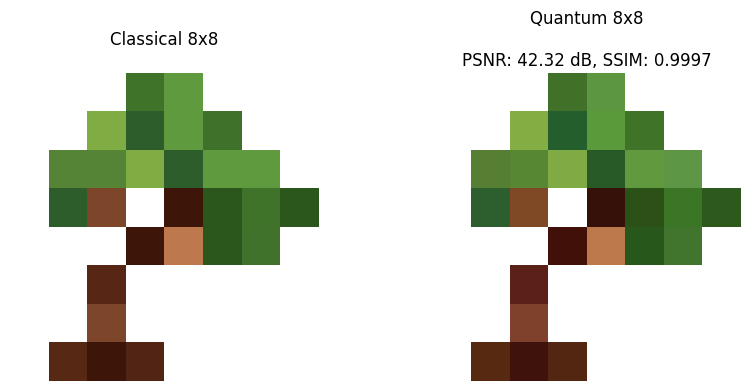


=== Processing 16x16 image ===
Total qubits: 11
PSNR: 36.31 dB, SSIM: 0.9984


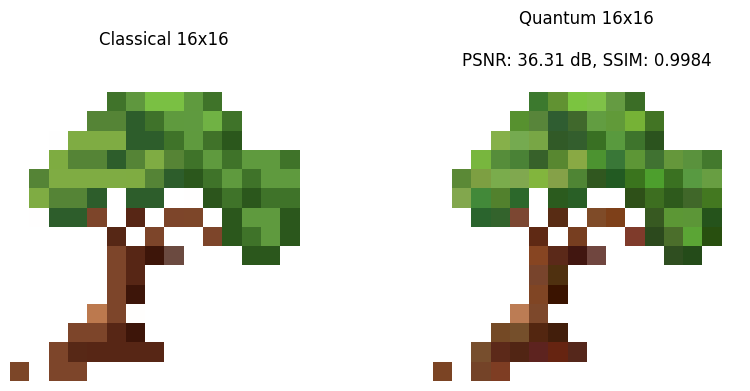


=== Processing 32x32 image ===
Total qubits: 13
PSNR: 36.65 dB, SSIM: 0.9960


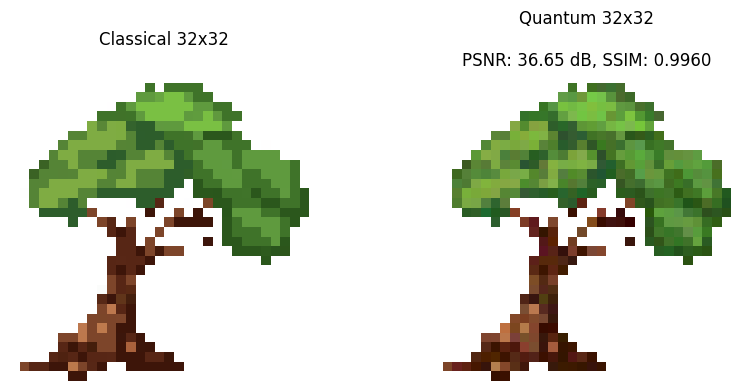

In [12]:
image_path = 'Tree_Sample.jpg'
sizes = [8, 16, 32]

for size in sizes:
    print(f"\n=== Processing {size}x{size} image ===")
    img = load_and_prepare_image(image_path, target_size=size)

    circuit, qubits, coord_qubits, color_qubits = mcqi_circuit(img)
    print("Total qubits:", len(qubits))

    counts = run_sim(circuit, repetitions=50000 if size<=16 else 200000)
    quantum_img = reconstruct_mcqi(img, counts, coord_qubits, color_qubits)

    # PSNR & SSIM
    psnr_val = psnr(img, quantum_img, data_range=255)
    win_size = min(size, 7)
    if win_size % 2 == 0: win_size -= 1
    ssim_val = ssim(img, quantum_img, data_range=255, channel_axis=-1, win_size=win_size)
    print(f"PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")

    # Plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title(f"Classical {size}x{size}\n")
    plt.axis('off')
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.title(f"Quantum {size}x{size}\n\nPSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}")
    plt.axis('off')
    plt.imshow(quantum_img)
    plt.show()

